In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

## 3.1 MNIST

In [29]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [30]:
X, y = mnist['data'], mnist['target']

In [31]:
X.shape

(70000, 784)

In [32]:
y.shape

(70000,)

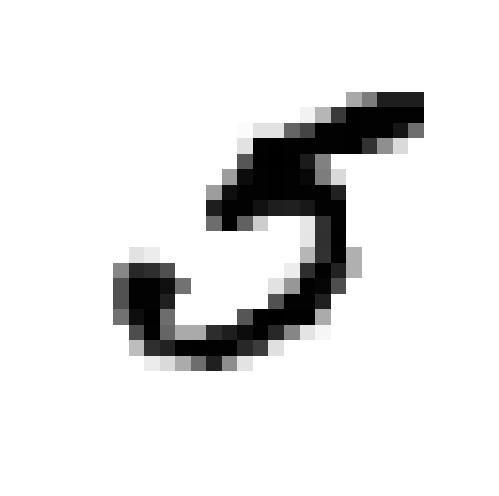

In [48]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = plt.cm.binary,
           interpolation="nearest")
plt.axis("off");

In [53]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [54]:
np.random.seed(42)
shuffle_index = np.random.permutation(60000)

In [55]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 저하됩니다.<br>
데이터셋을 섞으면 이런 문제를 해결 할 수 있습니다.

## 3.2 이진분류기 훈련

5만 식별해보겠습니다. '5-감지기'는 5와 5아님 두개의 클래스를 구분 할 수 있는 이진분류기의 한 예입니다.

In [56]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

SGDClassifier를 사용하여 확률적 경사하강법(stochastic gradient descent) 분류기로 시작해보겠습니다.<br>
이 분류기는 매우 큰 데이터넷을 효율적으로 처리하는 장점이 있습니다.<br>

In [57]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [58]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [60]:
from sklearn.model_selection import StratifiedKFold # 클래스별 비율이 유지되도록 폴드를 만들기 위함
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    #clone_clf = SGDClassifier(max_iter=5, random_state=42)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [61]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
#모델, 데이터, 레이블

array([0.9502 , 0.96565, 0.96495])

95%의 정확도를 나타냅니다.

In [62]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [63]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

5의 데이터가 전체의 10%이기때문에 5아님 이라 예측하게 되더라도 정확도는 90%를 나타냅니다.<br>
이런 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유입니다.<br>
특히 불균형한 데이터셋을 다룰때 그렇습니다.

In [45]:
np.bincount(y_train.astype(int))

array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

### 3.3.2 오차행렬

분류기의 성능을 평가하는 더 좋은 방법은 오차행렬(confusion matrix)를 조사하는 것입니다.<br>
cross_val_predict() 함수는 k-fold 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측값을 반환합니다.<br>

In [64]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [67]:
y_train_5

array([False, False, False, ..., False, False, False])

In [68]:
y_train_pred

array([False, False, False, ..., False, False, False])

In [69]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

행은 **실제클래스**를 나타내고 열은 **예측 클래스를** 나타냅니다.<br>
행렬의 첫번째 행은 '5아님'(음성 클래스 negative class)에 대한 것으로, 53272개를 '5아님'으로 정확하게 분류(진짜음성 true negative)했습니다.<br>
나머지 1307개는 '5'라고 잘못 분류했습니다.(거짓 양성 false positive)<br>
행렬의 두번째 행은 '5'(양성 클래스 positive class)에 대한 것으로, 1077개를 '5아님'으로 잘못 분류했습니다.(거짓 양성 false positive)<br>
나머지 4344개를 정확히 '5'라고 분류했습니다.(진짜 양성 true positive). <br><br>
완벽하게 분류했다면 대각성분이 0이 아닌값이 됩니다

In [70]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

오차 행렬이 많은 정보를 주지만 요약된 지표가 필요할 때가 있습니다.<br>
양성 예측의 정확도입니다. 이를 정밀도(precision)이라고 합니다.<br><br>


<table>
    <tr>
        <td></td><td></td><td colspan=2>예측</td>
    </tr>
    <tr>
        <td></td><td></td><td>음성</td><td>양성</td>
    </tr>
    <tr>
        <td rowspan=2>실제</td><td>음성</td><td>TN</td><td>FP</td>
    </tr>
    <tr>
        <td>양성</td><td>FN</td><td>TP</td>
    </tr>
</table>

$precison = \dfrac{TP}{TP + FP}$ ('5'라고 예측한것중 정답('5')인 비율)
<br> 
<br>

TP(5를 5라고 예측)는 진짜 양성의 수이고, FP(5를 5아님으로 예측)는 거짓 양성의 수입니다.<br>
정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적입니다.<br>
재현율은 분류기가 저확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성비율(TPR)이라고 합니다.<br><br>

$recall = \dfrac{TP}{TP+FN}$ ('5'인 것중 정답('5')으로 예측한 비율)


### 3.3.3 정밀도와 재현율

In [71]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), 4066 / (4066+1085)

(0.7687135020350381, 0.7893612890700835)

In [72]:
recall_score(y_train_5, y_train_pred), 4066 / (4066+1355)

(0.801328168234643, 0.7500461169525918)

5로 판변된 이미지중 77%만 정확합니다. 더군다나 전체 숫자 5에서 80%만 5라고 분류했습니다.<br>

정밀도와 재현율을 **$F_1$ 점수** 라고 하는 하나의 숫자로 만들면 편리할 때가 있습니다.<br>
특히 두 분류기를 비교할 때 좋습니다. $F_1$점수는 정밀도와 재현율의 조화평균으로 구합니다.<br><br>

$
F_1 = \dfrac{2}{\dfrac{1}{정밀도}+\dfrac{1}{재현율}} = 2 \times \dfrac{정밀도 \times 재현율}{정밀도 + 재현율} 
$

In [73]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [75]:
pr = precision_score(y_train_5, y_train_pred)
rr = recall_score(y_train_5, y_train_pred)
2 * (pr*rr)/(pr+rr)

0.7846820809248555

정밀도와 재현율이 비슷한 분류기에서는 $F_1$점수가 높습니다.<br>
상황에 따라 정밀도가 중유할 수도 있고 재현율이 중요할 수도 있습니다.<br>

어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해보겠습니다<br>
재현율은 높으나 정말 나쁜 동영상이 몇개 노출되는 것보다 좋은 동영상이 많이 제외더다라도 안전한 것들만 노출시키는, 정밀도가 높은 분류기를 선호 할 것입니다.


다른예로, 감시 카메라를 통해 도둑을 잡아내는 분류기를 훈련시킨다고 가정해보겠습니다.<br>
분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모릅니다.<br>
(도둑이 아닌사람들도 도둑으로 무조건 의심하므로 거의 모든 도둑을 잡을수 있습니다.)
    

재현율과 정밀도 모두를 얻을 수는 없습니다. 둘은 반비례관계입니다. 이를 정밀도/재현율 트레이드오프라고 합니다.

### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보겠습니다.<br>
이 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산합니다.<br>
이 점수가 임계값보다 크면 샘플을 양성클래스에 할당하고 그렇지않으면 음성 클래스에 할당합니다.<br>

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능합니다.<br>
decision_function() 메서드를 사용하여 각 샘플의 점수를 얻을 수 있습니다. 이 점수를 기반으로 원하는 임계값을 정해 예측을 만들 수 있습니다.

In [79]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [82]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [83]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

임계값을 높이면 재현율이 줄어든다는 것을 보여줍니다. <br>
적절한 임계값을 어떻게 정할 수 있을까요? 이를 위해서는 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야합니다.

In [84]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [86]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

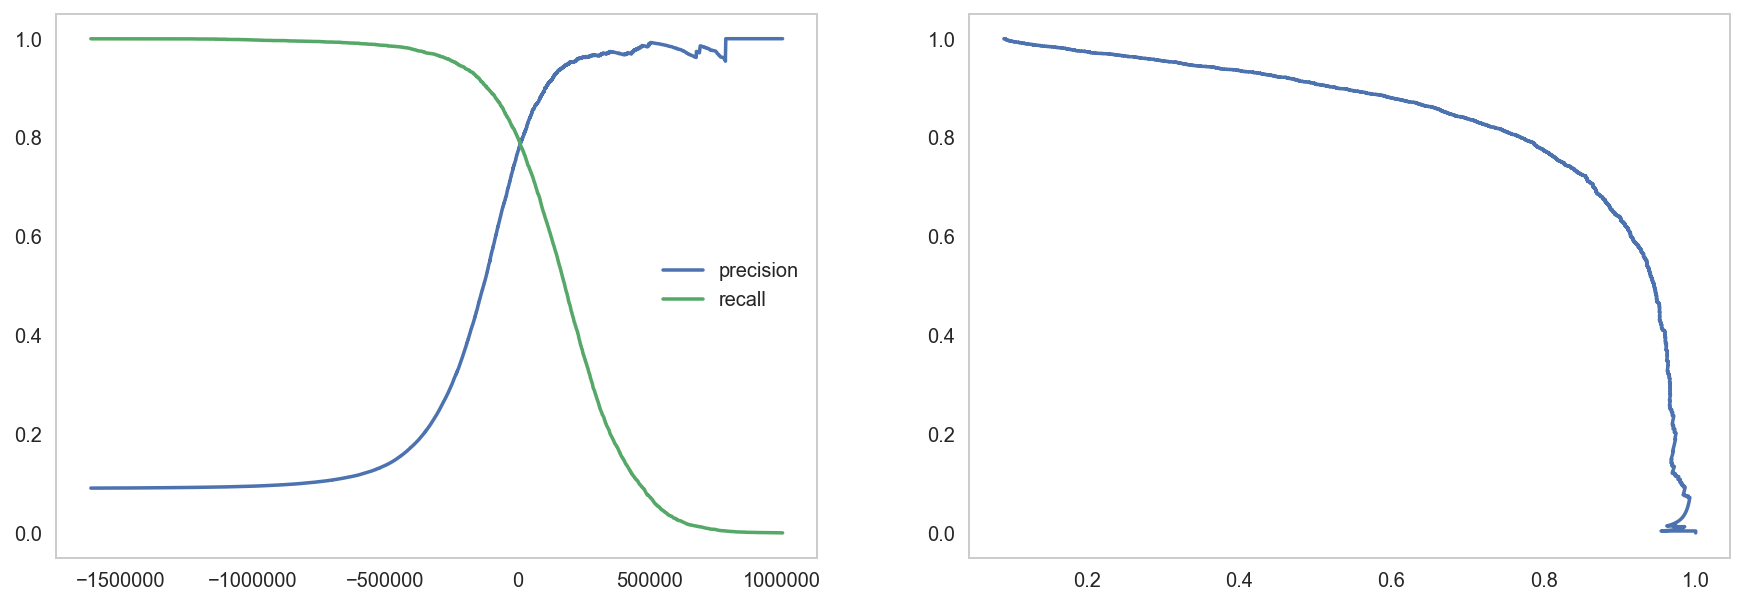

In [116]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.legend()
plt.grid(False)

plt.subplot(122)
plt.plot(precisions, recalls)
plt.grid(False);

In [106]:
res = []
for th in np.linspace(-1000000, 1000000, 10000):
    r = (y_scores > th)
    
    rr = y_train_5[r==True].astype(int)
    rr = np.sum(rr)/len(rr)
    
    pr = r[y_train_5==True].astype(int)
    pr = np.sum(pr)/len(pr)
    
    res.append([rr, pr])
res = np.array(res)

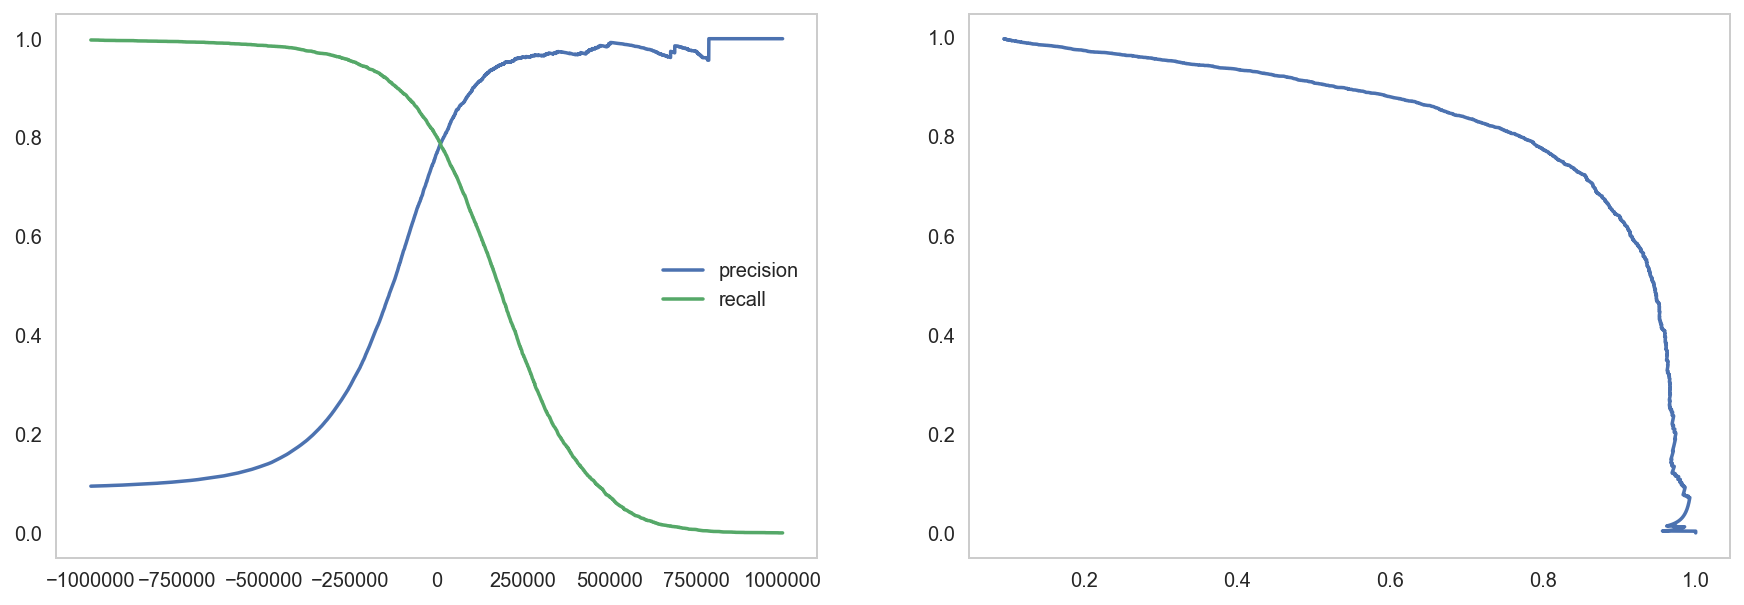

In [118]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.linspace(-1000000, 1000000, 10000), res[:,0], label='precision')
plt.plot(np.linspace(-1000000, 1000000, 10000), res[:,1], label='recall')
plt.legend()
plt.grid(False)

plt.subplot(122)
plt.plot(res[:,0], res[:, 1])
plt.grid(False);

이제 작업에 맞는 최선의 정밀도/재현율 트레이드오프를 마드는 임계값을 선택하면됩니다.<br>
재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작합니다.<br>
이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋습니다.<br>

정밀도 90%를 달성하는 것이 목표라고 가정해봅시다. 임계값 70000정도라는 것을 알 수 있습니다.

In [119]:
y_train_pred_90 = (y_scores > 70000)

In [120]:
precision_score(y_train_5, y_train_pred_90)

0.8659205116491548

In [121]:
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

### 3.3.5 ROC곡선

**수신기 조작 특성**(ROC) 곡선도 이진 분류에서 널리 사용하는 도구입니다. <br>
정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율(FPR)에 대한 진짜 양성비율(TPR)의 곡선입니다.<br>

In [128]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

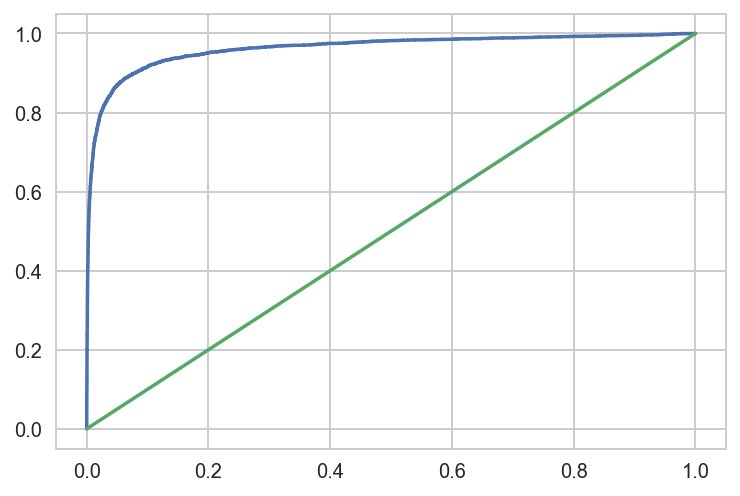

In [127]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1]);

In [132]:
score_idx = np.argsort(y_scores)[::-1] # 정렬하고 양수부터

In [219]:
ys = y_scores[score_idx][::20]
yh = y_train_5[score_idx][::20]

res = []
for t in ys:
    r = ys < t
    
    tpr = r[yh==True].astype(int)
    tpr = sum(tpr)/len(tpr)
    
    fpr = r[yh==False].astype(int)
    fpr = (sum(fpr)/len(fpr))

    res.append([tpr, fpr])

res = np.array(res)

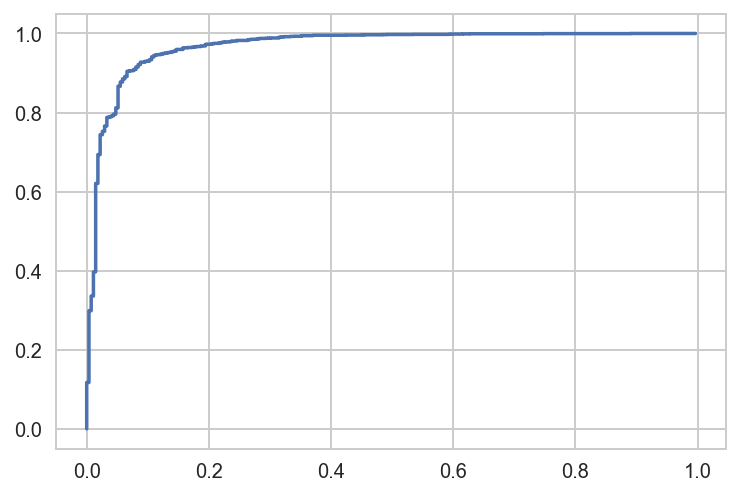

In [221]:
plt.plot(res[:,0], res[:, 1]);

In [81]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [82]:
y_scores_forest = y_probas_forest[:, 1]

In [84]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

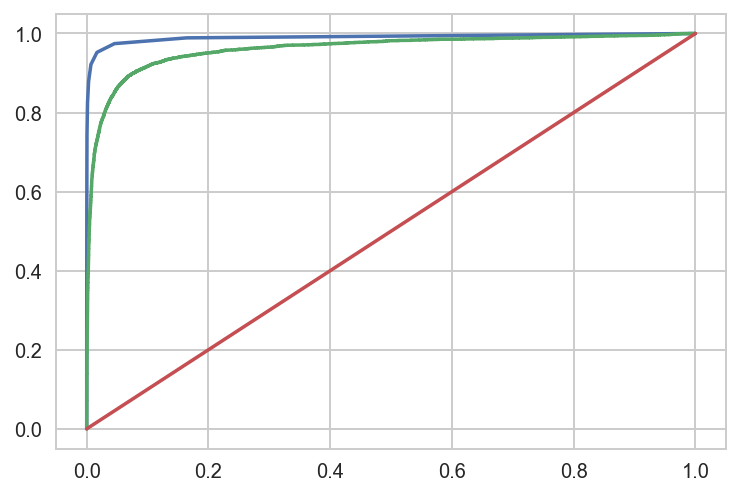

In [86]:
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

### 3.4 다중 분류기

- 랜덤포레스트 분류기, 나이브베이즈 분류기는 다중 분류 가능
- 서포트벡터머신, 선형분류기는 이진분류만 가능
- 일대다 OvA 전략
- 일대일 OvO 전략

In [92]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [93]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [94]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -21282.6846224 , -320715.91157835, -429886.26401982,
         -14536.60131611, -378105.80063926,   94143.49803969,
        -630004.64162094, -226670.7511395 , -710537.01967668,
        -629744.80950846]])

가장 높은 점수는 5가 해당

In [95]:
np.argmax(some_digit_scores)

5

In [96]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [97]:
sgd_clf.classes_[5]

5.0

In [98]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [99]:
len(ovo_clf.estimators_)

45

In [101]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [102]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [103]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88197361, 0.86099305, 0.85807871])

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90831834, 0.91079554, 0.91023654])

In [106]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5738,    3,   20,   12,   10,   49,   40,    9,   40,    2],
       [   1, 6472,   44,   23,    5,   40,    6,   10,  130,   11],
       [  51,   41, 5338,   87,   76,   26,   95,   51,  175,   18],
       [  46,   41,  148, 5336,    3,  238,   37,   50,  132,  100],
       [  17,   29,   45,    8, 5343,   10,   55,   31,   81,  223],
       [  68,   40,   37,  191,   69, 4629,  104,   27,  158,   98],
       [  31,   23,   59,    2,   38,   94, 5623,    7,   41,    0],
       [  25,   22,   74,   29,   54,   10,    4, 5785,   16,  246],
       [  51,  147,   78,  151,   10,  154,   60,   27, 5035,  138],
       [  44,   35,   27,   87,  154,   35,    2,  202,   75, 5288]])

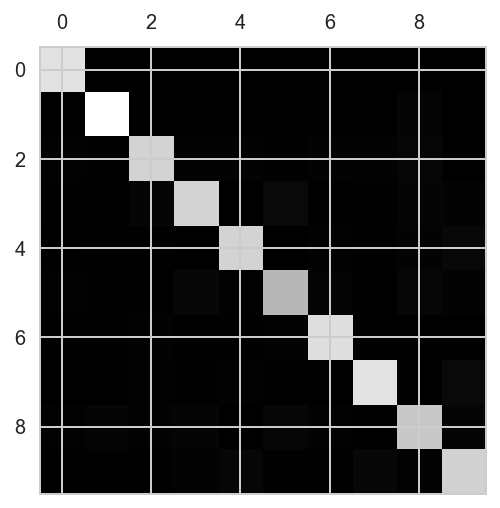

In [107]:
plt.matshow(conf_mx, cmap=plt.cm.gray);

In [111]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

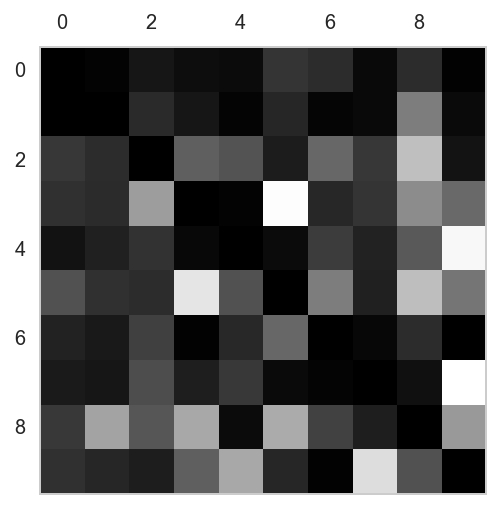

In [122]:
np.fill_diagonal(norm_conf_mx, 0 )
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.grid();

In [123]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [124]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [126]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)

Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_

KeyboardInterrupt: 

In [127]:
import random as rnd

In [131]:
noise = np.random.randint(0, 100, (len(X_train), 784))

In [132]:
X_train_mod = X_train + noise

In [133]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [134]:
y_train_mod = X_train
y_test_mod = X_test

In [136]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[30]])

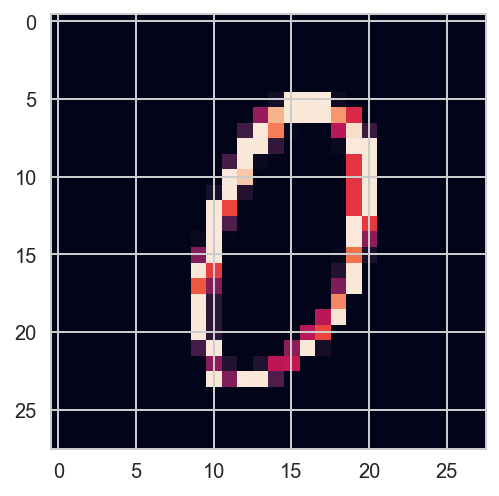

In [138]:
plt.imshow(clean_digit.reshape(28, 28))